In [11]:
import os
os.environ["CUDA_VISIBLE_DEVICES"] = "3"

import torch
import torch.autograd.functional as F
import torch.distributions as dist

import numpy as np
import matplotlib.pyplot as plt
from matplotlib.animation import FuncAnimation

import pandas as pd
%matplotlib inline

# Retina display
%config InlineBackend.figure_format = 'retina'

In [12]:
from tueplots import bundles

plt.rcParams.update(bundles.beamer_moml())
# plt.rcParams.update(bundles.icml2022())


# Also add despine to the bundle using rcParams
plt.rcParams["axes.spines.right"] = False
plt.rcParams["axes.spines.top"] = False

# Increase font size to match Beamer template
plt.rcParams["font.size"] = 16
# Make background transparent
plt.rcParams["figure.facecolor"] = "none"

In [13]:
import hamiltorch


In [14]:
hamiltorch.set_random_seed(123)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [15]:
device


device(type='cuda')

In [16]:
gt_distribution = torch.distributions.Normal(0, 1)


# Samples from the ground truth distribution
def sample_gt(n):
    return gt_distribution.sample((n,))


samples = sample_gt(1000)

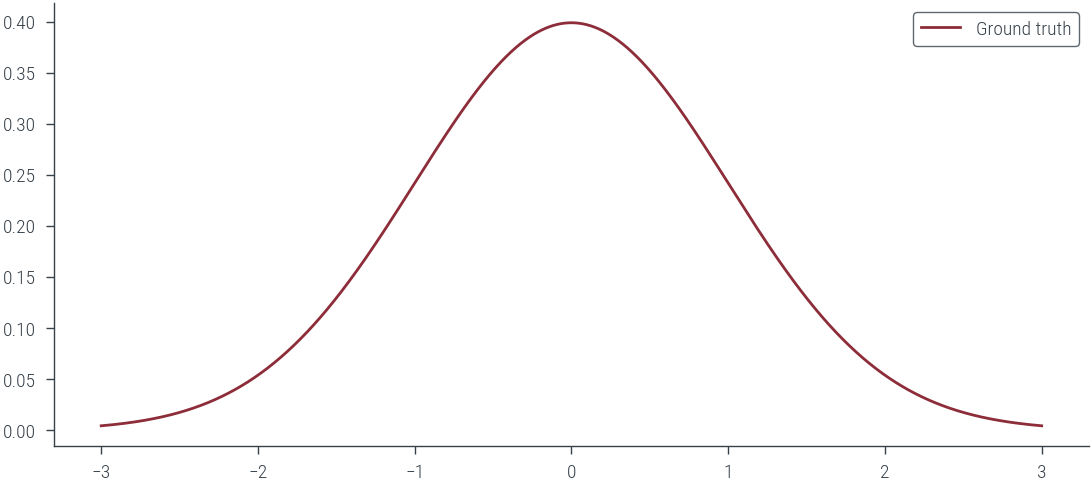

In [17]:
x_lin = torch.linspace(-3, 3, 1000)
y_lin = torch.exp(gt_distribution.log_prob(x_lin))

plt.plot(x_lin, y_lin, label="Ground truth")
plt.legend()

In [18]:
# Logprob function to be passed to Hamiltorch sampler
def logprob(x):
    return gt_distribution.log_prob(x)


In [19]:
logprob(torch.tensor([0.0]))


tensor([-0.9189])

In [20]:
# Initial state
x0 = torch.tensor([0.0])
num_samples = 5000
step_size = 0.3
num_steps_per_sample = 5
hamiltorch.set_random_seed(123)


In [21]:
params_hmc = hamiltorch.sample(
    log_prob_func=logprob,
    params_init=x0,
    num_samples=num_samples,
    step_size=step_size,
    num_steps_per_sample=num_steps_per_sample,
)

Sampling (Sampler.HMC; Integrator.IMPLICIT)
Time spent  | Time remain.| Progress             | Samples   | Samples/sec
0d:00:00:06 | 0d:00:00:00 | #################### | 5000/5000 | 747.63       
Acceptance Rate 0.99


In [14]:
params_hmc = torch.tensor(params_hmc)


Text(0, 0.5, 'Parameter value')

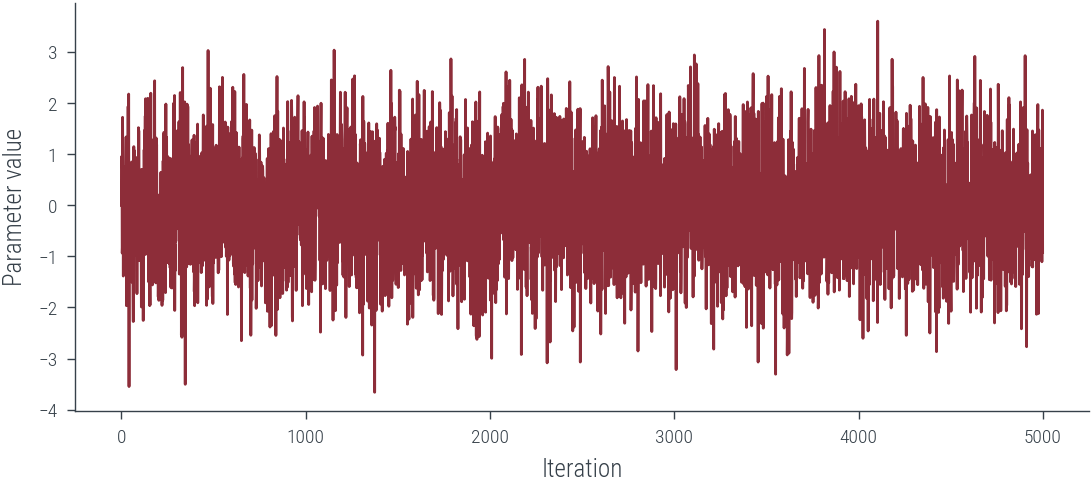

In [15]:
# Trace plot
plt.plot(params_hmc, label="Trace")
plt.xlabel("Iteration")
plt.ylabel("Parameter value")

Text(0, 0.5, 'Parameter value')

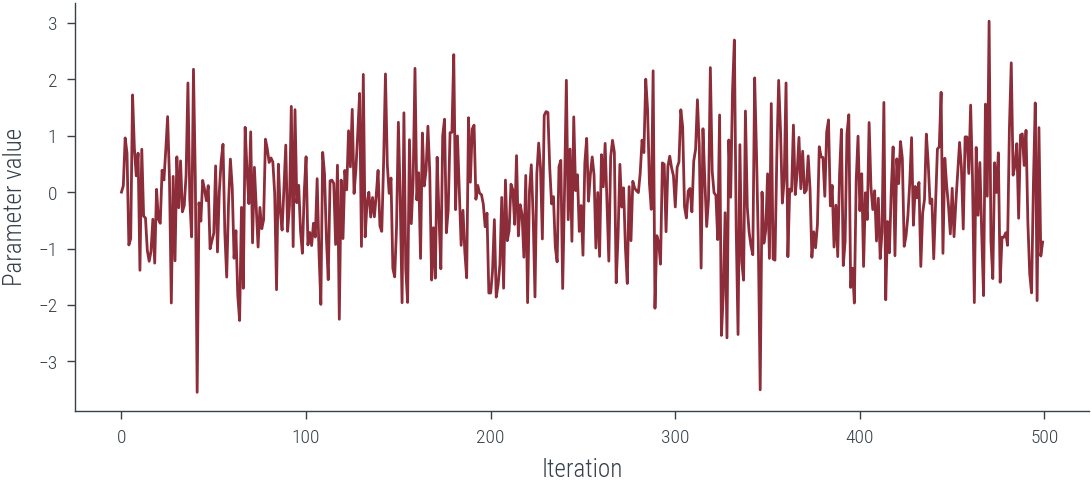

In [16]:
# view first 500 samples
plt.plot(params_hmc[:500], label="Trace")
plt.xlabel("Iteration")
plt.ylabel("Parameter value")

<frozen importlib._bootstrap>:228: RuntimeWarning: scipy._lib.messagestream.MessageStream size changed, may indicate binary incompatibility. Expected 56 from C header, got 64 from PyObject
/tmp/ipykernel_884819/4229748728.py:5: FutureWarning: 

`shade` is now deprecated in favor of `fill`; setting `fill=True`.
This will become an error in seaborn v0.14.0; please update your code.

  sns.kdeplot(params_hmc.detach().numpy(), label="Samples", shade=True, color="C1")


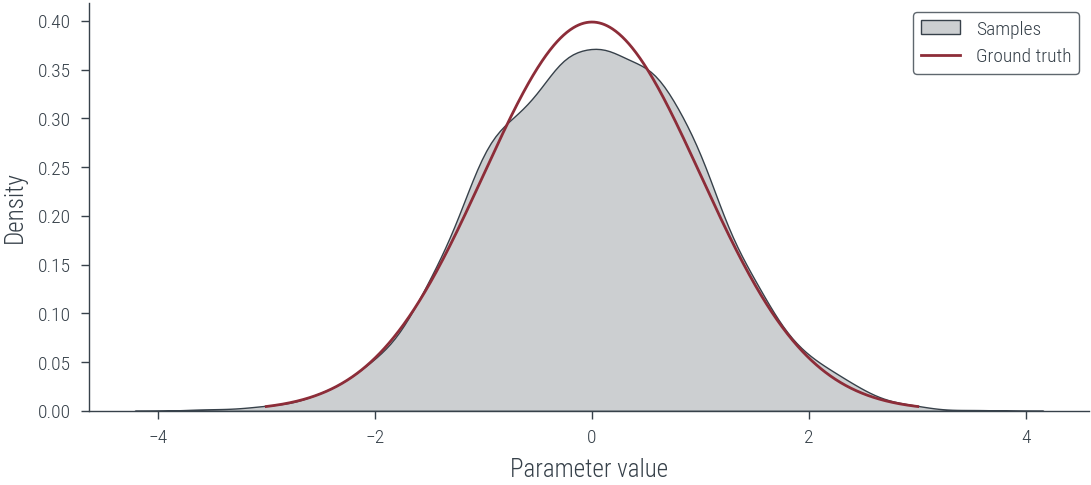

In [17]:
# KDE plot
import seaborn as sns

plt.figure()
sns.kdeplot(params_hmc.detach().numpy(), label="Samples", shade=True, color="C1")
plt.plot(x_lin, y_lin, label="Ground truth")
plt.xlabel("Parameter value")
plt.ylabel("Density")
plt.legend()

In [18]:
def plot_samples_gif(x_lin, y_lin, params_hmc, filename, frames=50):
    fig, ax = plt.subplots()
    plt.plot(x_lin, y_lin, label="Ground truth")
    scatter = ax.scatter([], [], color="C1", marker="x", s=100)

    # Function to update the animation
    def update(frame):
        scatter.set_offsets(np.array([[params_hmc[frame], 0]]))
        return (scatter,)

    # Create the animation
    anim = FuncAnimation(fig, update, frames=frames, blit=True)

    # Save the animation as a GIF or video file (you can change the filename and format)
    anim.save(filename, dpi=200)

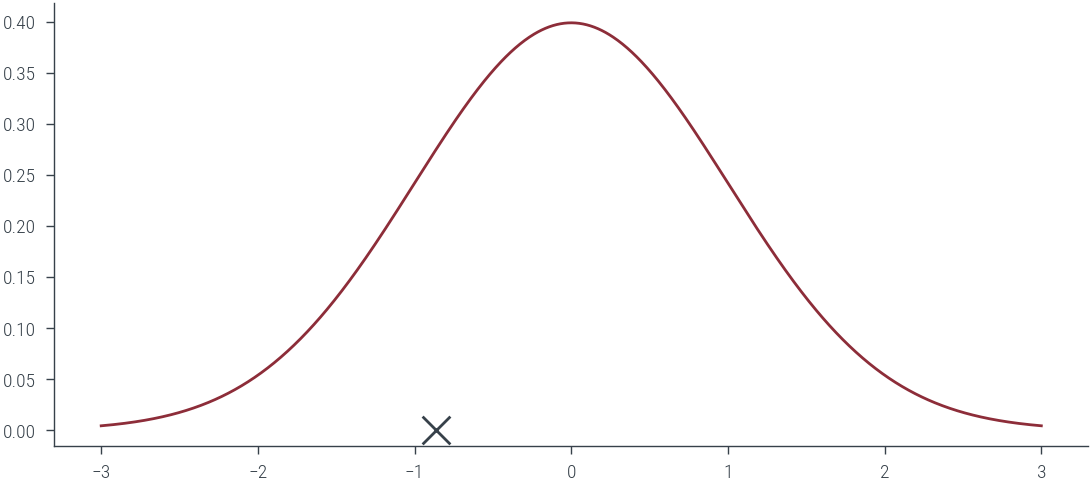

In [19]:
plot_samples_gif(
    x_lin, y_lin, params_hmc, "../figures/sampling/mcmc/hamiltorch-samples-normal.gif"
)

![](../figures/sampling/mcmc/hamiltorch-samples-normal.gif)

/tmp/ipykernel_884819/521934876.py:11: FutureWarning: 

`shade` is now deprecated in favor of `fill`; setting `fill=True`.
This will become an error in seaborn v0.14.0; please update your code.

  sns.kdeplot(samples.numpy(), label="Samples", shade=True, color="C1")


<Axes: ylabel='Density'>

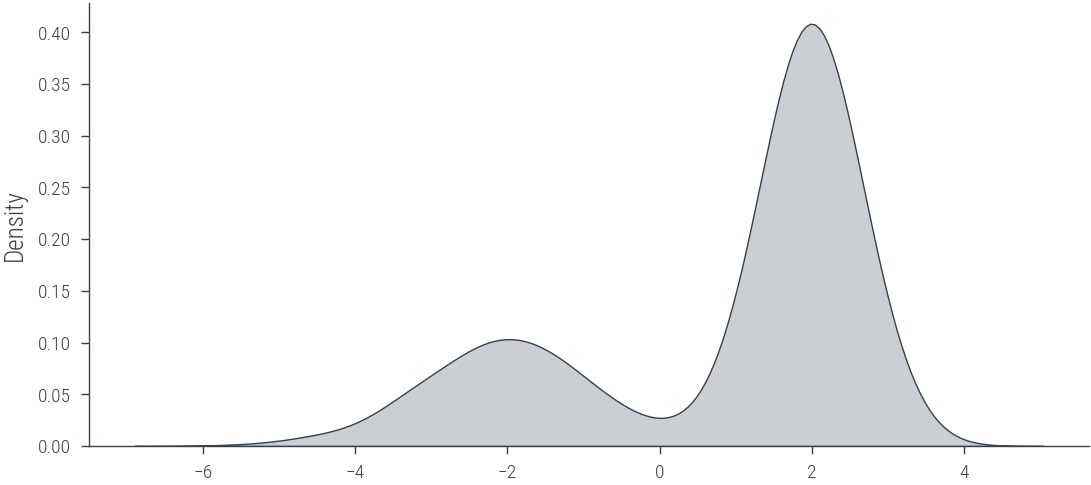

In [20]:
# sample from Mixture of Gaussians

mog = dist.MixtureSameFamily(
    mixture_distribution=dist.Categorical(torch.tensor([0.3, 0.7])),
    component_distribution=dist.Normal(
        torch.tensor([-2.0, 2.0]), torch.tensor([1.0, 0.5])
    ),
)

samples = mog.sample((1000,))
sns.kdeplot(samples.numpy(), label="Samples", shade=True, color="C1")

In [21]:
# Logprob function to be passed to Hamiltorch sampler
def logprob(x):
    return mog.log_prob(x)


logprob(torch.tensor([0.0]))

tensor([-4.1114])

In [22]:
# Initial state
x0 = torch.tensor([0.0])
num_samples = 5000
step_size = 0.3
num_steps_per_sample = 5
hamiltorch.set_random_seed(123)

params_hmc = hamiltorch.sample(
    log_prob_func=logprob,
    params_init=x0,
    num_samples=num_samples,
    step_size=step_size,
    num_steps_per_sample=num_steps_per_sample,
)

Sampling (Sampler.HMC; Integrator.IMPLICIT)
Time spent  | Time remain.| Progress             | Samples   | Samples/sec
0d:00:00:11 | 0d:00:00:00 | #################### | 5000/5000 | 439.77       
Acceptance Rate 0.99


In [23]:
params_hmc = torch.tensor(params_hmc)

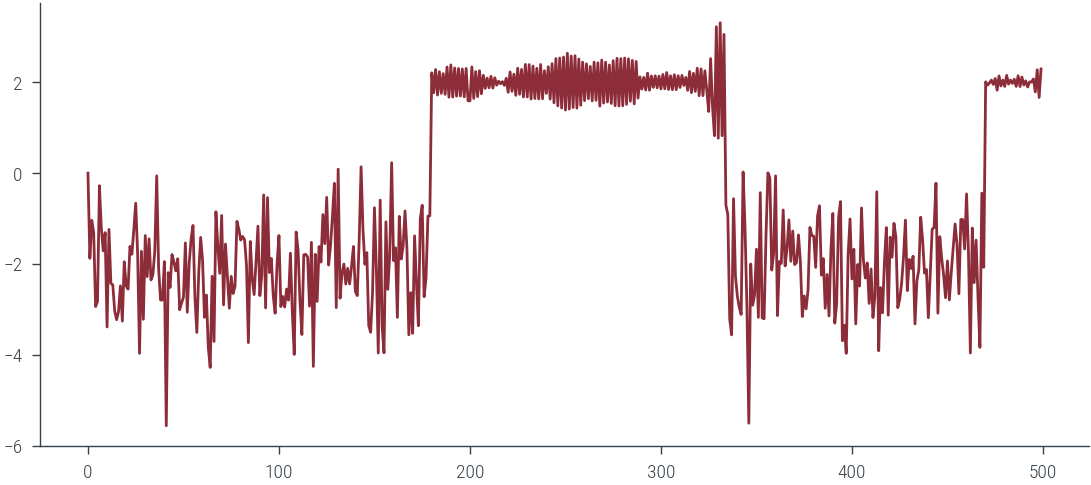

In [24]:
# Trace plot
plt.plot(params_hmc[:500], label="Trace")

KeyboardInterrupt: 

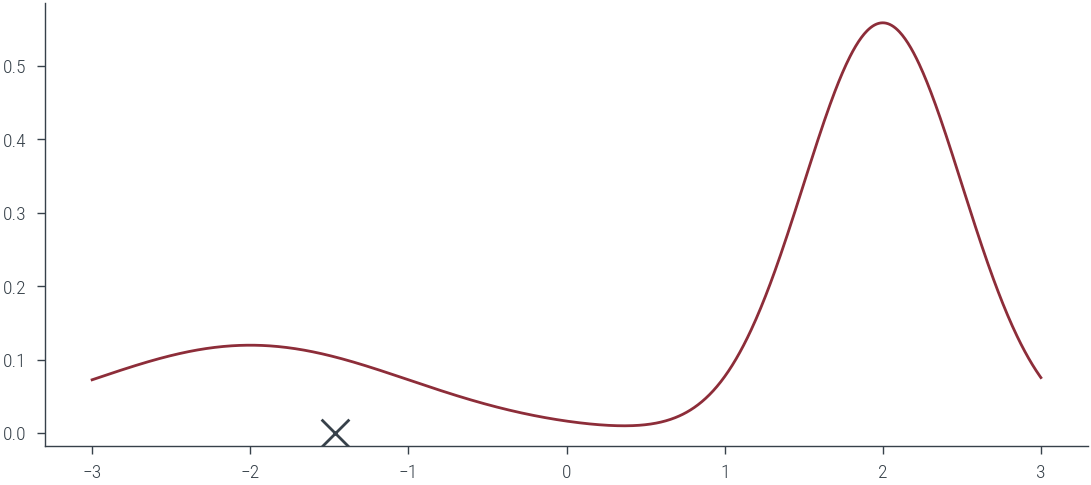

In [25]:
y_lin = torch.exp(mog.log_prob(x_lin))
plot_samples_gif(
    x_lin,
    y_lin,
    params_hmc,
    "../figures/sampling/mcmc/hamiltorch-samples-mog.gif",
    frames=300,
)

In [ ]:
def p_tilde(x):
    # normalising constant for standard normal distribution
    Z = torch.sqrt(torch.tensor(2 * np.pi))
    return dist.Normal(0, 1).log_prob(x).exp() * Z


def p_tilde_log_prob(x):
    # normalising constant for standard normal distribution
    Z = torch.sqrt(torch.tensor(2 * np.pi))
    return dist.Normal(0, 1).log_prob(x) + torch.log(Z)

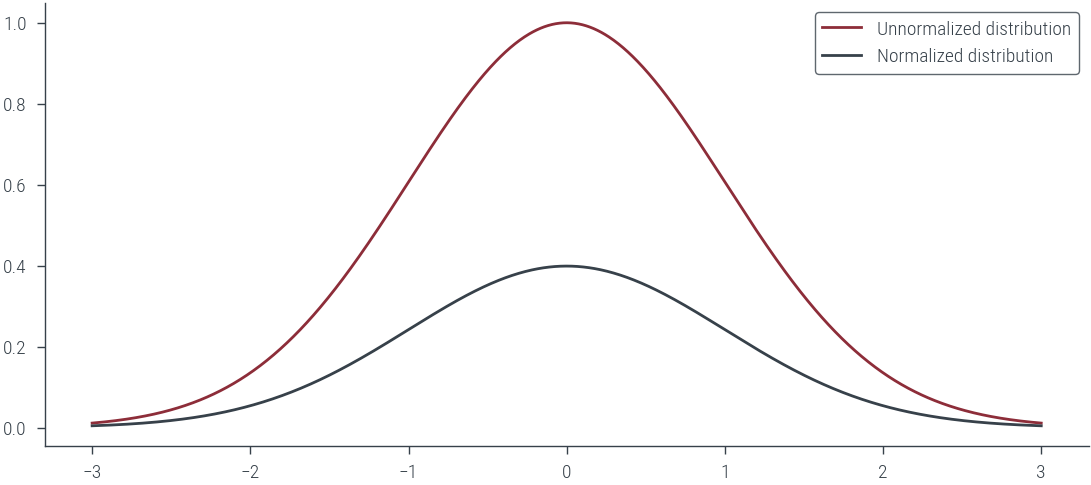

In [ ]:
# Plot unnormalized distribution
x_lin = torch.linspace(-3, 3, 1000)
y_lin = p_tilde(x_lin)
plt.plot(x_lin, y_lin, label="Unnormalized distribution")
# Plot normalized distribution
plt.plot(
    x_lin, dist.Normal(0, 1).log_prob(x_lin).exp(), label="Normalized distribution"
)
plt.legend()

In [ ]:
# HMC over unnormalized distribution


# Logprob function to be passed to Hamiltorch sampler
def logprob(x):
    return p_tilde_log_prob(x)

In [ ]:
# HMC
x0 = torch.tensor([0.0])
num_samples = 5000
step_size = 0.3
num_steps_per_sample = 5
hamiltorch.set_random_seed(123)

params_hmc = hamiltorch.sample(
    log_prob_func=logprob,
    params_init=x0,
    num_samples=num_samples,
    step_size=step_size,
    num_steps_per_sample=num_steps_per_sample,
)

params_hmc = torch.tensor(params_hmc)

Sampling (Sampler.HMC; Integrator.IMPLICIT)
Time spent  | Time remain.| Progress             | Samples   | Samples/sec
0d:00:00:10 | 0d:00:00:00 | #################### | 5000/5000 | 477.15       
Acceptance Rate 0.99


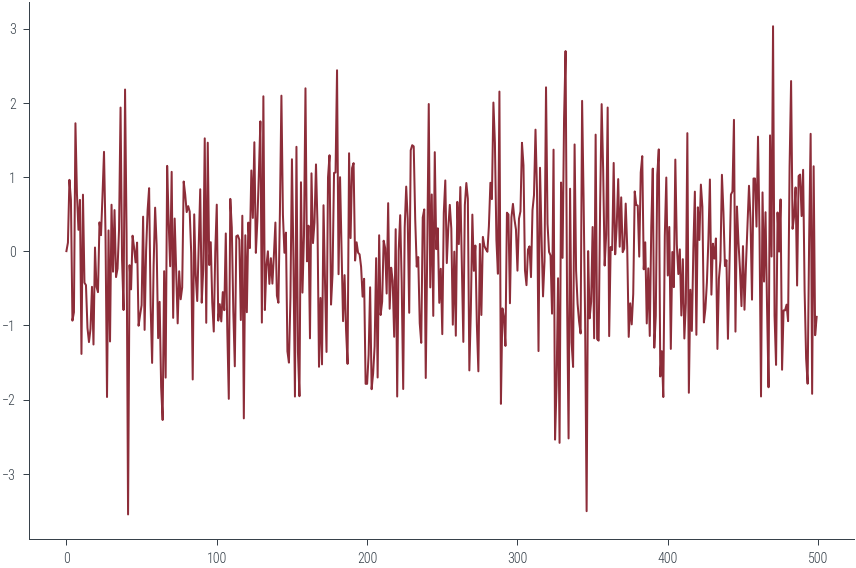

In [ ]:
# Trace plot
plt.plot(params_hmc[:500], label="Trace")

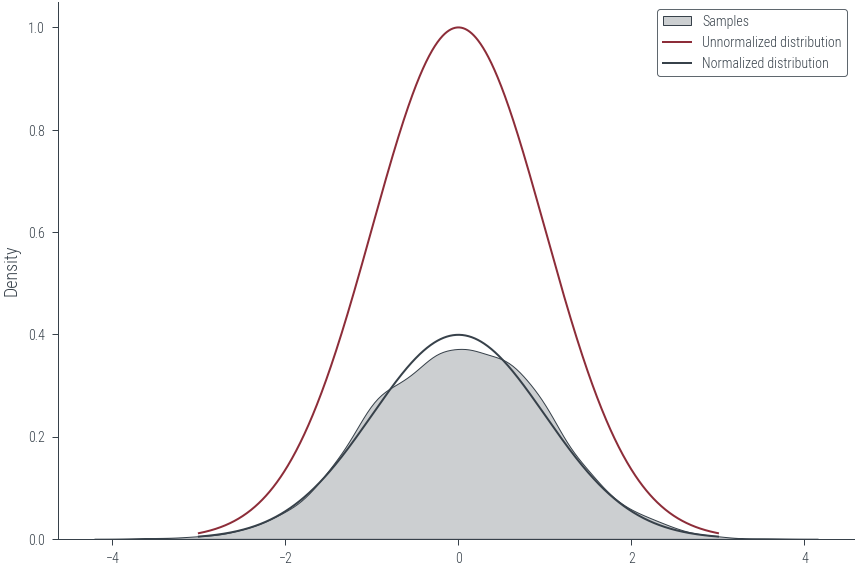

In [ ]:
# KDE plot
sns.kdeplot(params_hmc.detach().numpy(), label="Samples", shade=True, color="C1")
plt.plot(x_lin, y_lin, label="Unnormalized distribution")
plt.plot(
    x_lin, dist.Normal(0, 1).log_prob(x_lin).exp(), label="Normalized distribution"
)
plt.legend()

In [ ]:
# Coin toss

prior = dist.Beta(1, 1)
data = torch.tensor([1.0, 1.0, 1.0, 0.0, 0.0])
n = len(data)


def log_prior(theta):
    return prior.log_prob(theta)


def log_likelihood(theta):
    return dist.Bernoulli(theta).log_prob(data).sum()


def negative_log_joint(theta):
    return log_prior(theta) + log_likelihood(theta)

In [22]:
def run_hmc(logprob, x0, num_samples, step_size, num_steps_per_sample):
    torch.manual_seed(123)
    params_hmc = hamiltorch.sample(
        log_prob_func=logprob,
        params_init=x0,
        num_samples=num_samples,
        step_size=step_size,
        num_steps_per_sample=num_steps_per_sample,
    )
    return torch.stack(params_hmc)


In [ ]:
try:
    params_hmc_theta = run_hmc(negative_log_joint, torch.tensor([0.5]), 5000, 0.3, 5)
except Exception as e:
    print(e)


Sampling (Sampler.HMC; Integrator.IMPLICIT)
Time spent  | Time remain.| Progress             | Samples   | Samples/sec
0d:00:00:16 | 0d:00:00:00 | #################### | 5000/5000 | 305.55       
Acceptance Rate 0.99


In [ ]:
# Let us work instead with logits
def log_prior(logits):
    return prior.log_prob(torch.sigmoid(logits)).sum()


def log_likelihood(logits):
    return dist.Bernoulli(logits=logits).log_prob(data).sum()


def log_joint(logits):
    return log_prior(logits) + log_likelihood(logits)

In [ ]:
params_hmc_logits = run_hmc(log_joint, torch.tensor([0.0]), 1000, 0.3, 5)


Sampling (Sampler.HMC; Integrator.IMPLICIT)
Time spent  | Time remain.| Progress             | Samples   | Samples/sec
0d:00:00:03 | 0d:00:00:00 | #################### | 1000/1000 | 270.44       
Acceptance Rate 0.99


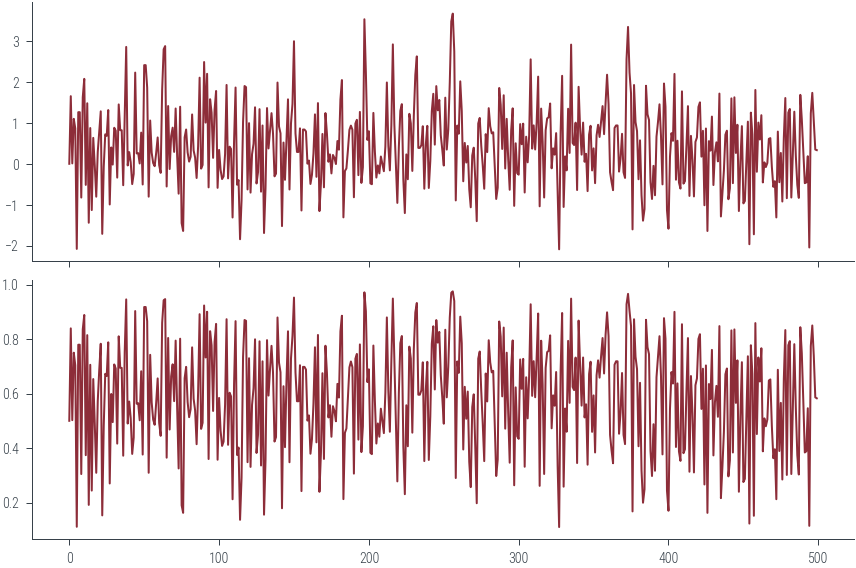

In [ ]:
fig, ax = plt.subplots(nrows=2, sharex=True)
ax[0].plot(params_hmc_logits[:500], label="Trace")
ax[1].plot(torch.sigmoid(params_hmc_logits[:500]), label="Trace")

In [ ]:
params_hmc_logits[:, 0]


tensor([ 0.0000e+00,  1.6534e+00,  9.6122e-03,  1.0988e+00,  8.6559e-01,
        -2.0808e+00,  1.2617e+00,  1.2617e+00, -8.2547e-01,  1.6278e+00,
         2.0763e+00, -5.1573e-01,  1.4796e+00, -1.4413e+00,  8.7425e-01,
        -1.1314e+00,  6.3342e-01, -3.6684e-02, -8.0399e-01,  2.9092e-01,
         7.8311e-01,  1.2826e+00, -1.7128e+00, -7.3525e-02,  7.2005e-01,
         6.8356e-01,  1.3137e+00, -9.9467e-01,  3.9936e-01, -1.9222e-02,
         8.8107e-01,  8.0997e-01, -3.3786e-01,  1.4515e+00,  8.2083e-01,
         8.2083e-01, -5.2393e-01,  1.1097e+00,  2.8575e+00, -3.9971e-02,
         2.8476e-01,  4.0993e-02, -4.9601e-01, -2.4742e-01,  2.2298e+00,
         2.5214e-01,  2.6092e-01,  7.6723e-03,  7.6258e-01, -5.0583e-01,
         2.4118e+00,  2.4118e+00,  1.8629e+00, -8.0357e-01,  1.0577e+00,
         2.7093e-01,  1.7729e-02, -5.8743e-02,  2.6657e-01,  6.4403e-01,
        -3.1467e-02, -2.2159e-01,  1.8147e+00,  2.7993e+00,  2.8776e+00,
        -5.5522e-01,  1.4121e+00, -1.2795e-01,  6.7

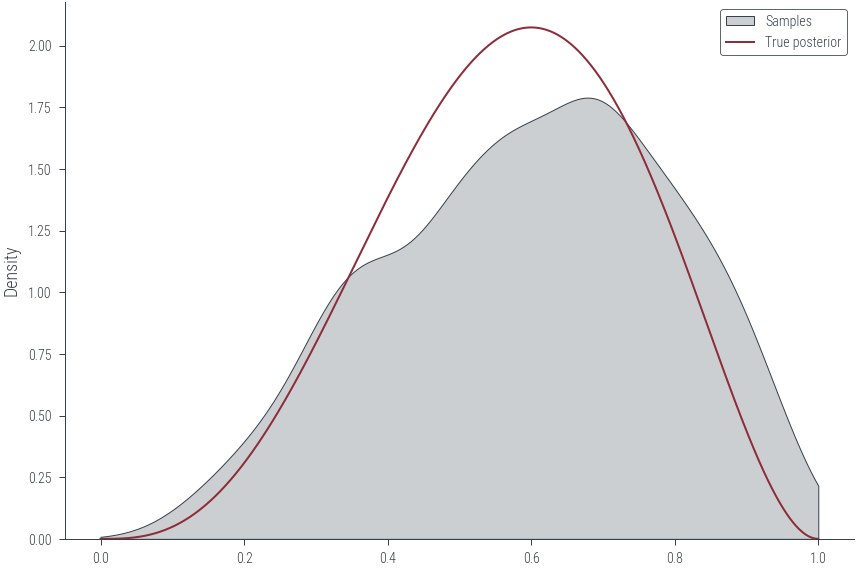

In [ ]:
# Plot posterior KDE using seaborn but clip to [0, 1]
sns.kdeplot(
    torch.sigmoid(params_hmc_logits[:, 0]).detach().numpy(),
    label="Samples",
    shade=True,
    color="C1",
    clip=(0, 1),
)
# True posterior
x_lin = torch.linspace(0, 1, 1000)
y_lin = dist.Beta(1 + 3, 1 + 2).log_prob(x_lin).exp()
plt.plot(x_lin, y_lin, label="True posterior")
plt.legend()

Text(0, 0.5, 'y')

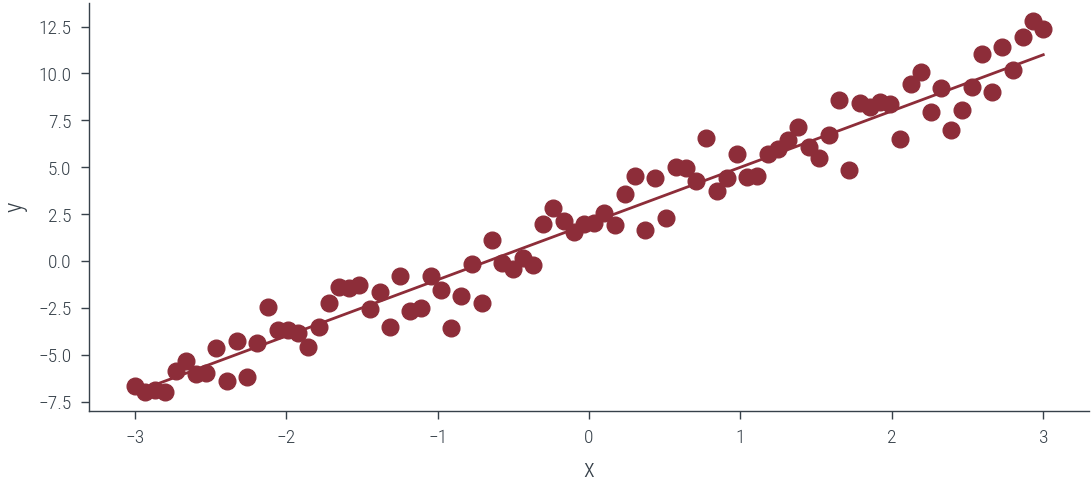

In [23]:
# Linear regression for 1 dimensional input using HMC

torch.manual_seed(123)
x_lin = torch.linspace(-3, 3, 90)
theta_0_true = torch.tensor([2.0])
theta_1_true = torch.tensor([3.0])
f = lambda x: theta_0_true + theta_1_true * x
eps = torch.randn_like(x_lin) * 1.0
y_lin = f(x_lin) + eps

plt.scatter(x_lin, y_lin, label="Data", color="C0")
plt.plot(x_lin, f(x_lin), label="Ground truth")
plt.xlabel("x")
plt.ylabel("y")

In [24]:
# Esimate theta_0, theta_1 using HMC assuming noise variance is known to be 1
def logprob(theta):
    y_pred = theta[0] + x_lin * theta[1]
    # print(y_pred.shape, y_lin.shape)
    # print(y_pred.shape, y_lin.shape, y_pred)
    return dist.Normal(y_pred, 1).log_prob(y_lin).sum()


def log_prior(theta):
    return dist.Normal(0, 1).log_prob(theta).sum()


def log_posterior(theta):
    log_prior_val = log_prior(theta)
    log_likelihood = logprob(theta)
    log_joint = log_prior_val + log_likelihood
    # print(log_joint, log_prior_val, log_likelihood)
    return log_joint


In [28]:
params = torch.tensor([0.1, 0.2])
print(params.dtype)
params_hmc_lin_reg = run_hmc(log_posterior, params, 1000, 0.1, 5)


torch.float32
Sampling (Sampler.HMC; Integrator.IMPLICIT)
Time spent  | Time remain.| Progress             | Samples   | Samples/sec
0d:00:00:03 | 0d:00:00:00 | #################### | 1000/1000 | 280.63       
Acceptance Rate 0.83


Sampling (Sampler.HMC; Integrator.IMPLICIT)
Time spent  | Time remain.| Progress             | Samples | Samples/sec
tensor(-1433.3967, grad_fn=<AddBackward0>) tensor(-1.8629, grad_fn=<SumBackward0>) tensor(-1431.5338, grad_fn=<SumBackward0>)
tensor(-1433.3967, grad_fn=<AddBackward0>) tensor(-1.8629, grad_fn=<SumBackward0>) tensor(-1431.5338, grad_fn=<SumBackward0>)
tensor(-355.0762, grad_fn=<AddBackward0>) tensor(-10.8475, grad_fn=<SumBackward0>) tensor(-344.2287, grad_fn=<SumBackward0>)
tensor(-729.5259, grad_fn=<AddBackward0>) tensor(-18.6343, grad_fn=<SumBackward0>) tensor(-710.8916, grad_fn=<SumBackward0>)
tensor(-1269.0886, grad_fn=<AddBackward0>) tensor(-9.7863, grad_fn=<SumBackward0>) tensor(-1259.3024, grad_fn=<SumBackward0>)
tensor(-218.4335, grad_fn=<AddBackward0>) tensor(-12.0944, grad_fn=<SumBackward0>) tensor(-206.3391, grad_fn=<SumBackward0>)
tensor(-1101.4713, grad_fn=<AddBackward0>) tensor(-19.0104, grad_fn=<SumBackward0>) tensor(-1082.4608, grad_fn=<SumBackward0>)
tensor(-1101.4713, grad_fn=<AddBackward0>) tensor(-19.0104, grad_fn=<SumBackward0>) tensor(-1082.4608, grad_fn=<SumBackward0>)
0d:00:00:00 | 0d:00:00:00 | #################### | 1/1 | 140.03       
Acceptance Rate 1.00

In [29]:
params_hmc_lin_reg


tensor([[0.1000, 0.2000],
        [1.7248, 0.6831],
        [2.1176, 5.2166],
        ...,
        [1.9162, 3.1325],
        [2.1559, 2.9292],
        [1.8733, 3.0645]])

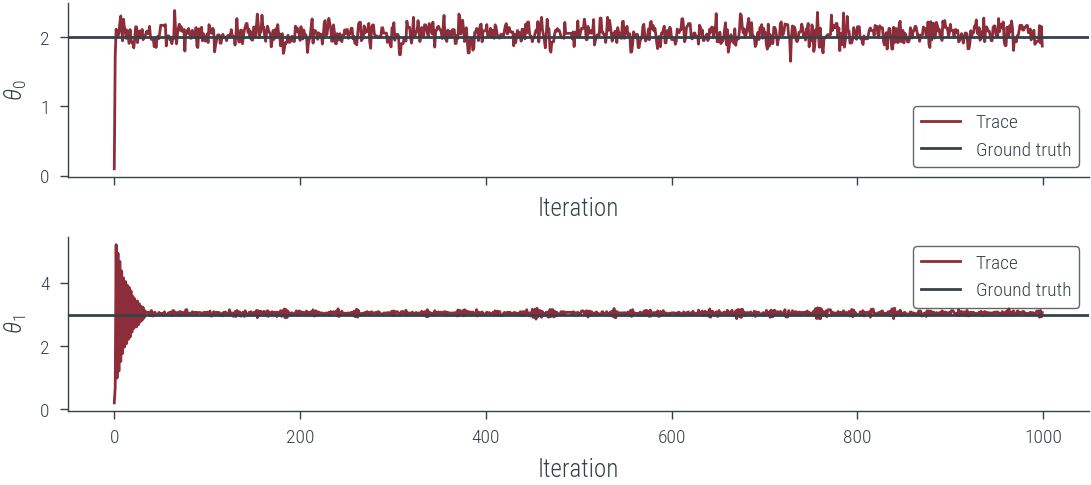

In [30]:
# Plot the traces corresponding to the two parameters
fig, axes = plt.subplots(2, 1, sharex=True)

for i, param_vals in enumerate(params_hmc_lin_reg.T):
    axes[i].plot(param_vals, label="Trace")
    axes[i].set_xlabel("Iteration")
    axes[i].set_ylabel(rf"$\theta_{i}$")

# Plot the true values as well
for i, param_vals in enumerate([theta_0_true, theta_1_true]):
    axes[i].axhline(param_vals.numpy(), color="C1", label="Ground truth")
    axes[i].legend()

NameError: name 'sns' is not defined

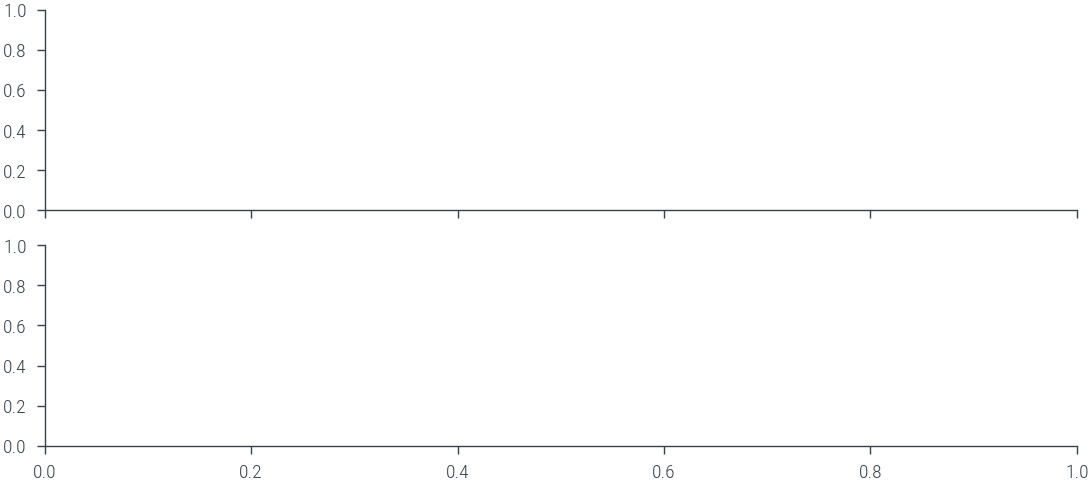

In [31]:
# Plot KDE of the samples for the two parameters
fig, axes = plt.subplots(2, 1, sharex=True)

for i, param_vals in enumerate(params_hmc_lin_reg.T):
    sns.kdeplot(
        param_vals.detach().numpy(), label="Samples", shade=True, color="C1", ax=axes[i]
    )
    axes[i].set_ylabel(rf"$\theta_{i}$")

# Plot the true values as well
for i, param_vals in enumerate([theta_0_true, theta_1_true]):
    axes[i].axvline(param_vals.numpy(), color="C0", label="Ground truth")
    axes[i].legend()

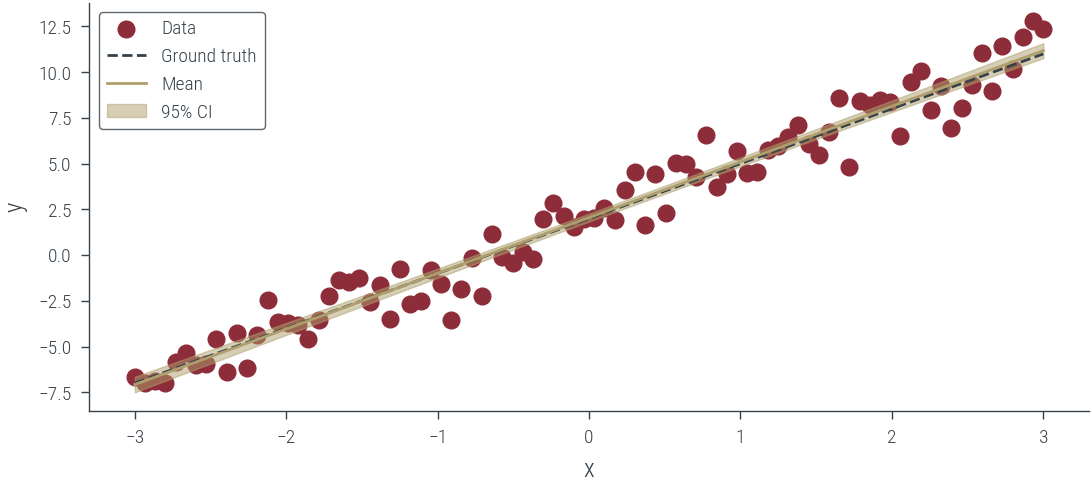

In [142]:
# Plot the posterior predictive distribution
plt.figure()
plt.scatter(x_lin, y_lin, label="Data", color="C0")
plt.plot(x_lin, f(x_lin), label="Ground truth", color="C1", linestyle="--")
plt.xlabel("x")
plt.ylabel("y")

# Get posterior samples. Thin first 100 samples to remove burn-in
posterior_samples = params_hmc_lin_reg[100:].detach()
y_hat = posterior_samples[:, 0].unsqueeze(1) + x_lin * posterior_samples[
    :, 1
].unsqueeze(1)

# Plot mean and 95% confidence interval

plt.plot(x_lin, y_hat.mean(axis=0), label="Mean", color="C2")
plt.fill_between(
    x_lin,
    y_hat.mean(axis=0) - 2 * y_hat.std(axis=0),
    y_hat.mean(axis=0) + 2 * y_hat.std(axis=0),
    alpha=0.5,
    label="95% CI",
    color="C2",
)
plt.legend()

In [32]:
# Using a neural network with HMC


class Net(torch.nn.Module):
    def __init__(self):
        super().__init__()
        self.fc1 = torch.nn.Linear(1, 1)

    def forward(self, x):
        x = self.fc1(x)
        return x

In [33]:
net = Net()
net


Net(
  (fc1): Linear(in_features=1, out_features=1, bias=True)
)

In [34]:
hamiltorch.util.flatten(net).shape


torch.Size([2])

In [35]:
theta_params = hamiltorch.util.flatten(net)
theta_params.shape


torch.Size([2])

In [36]:
params_list = hamiltorch.util.unflatten(net, theta_params)
params_list[0].shape, params_list[1].shape


(torch.Size([1, 1]), torch.Size([1]))

In [37]:
params_init = theta_params.clone().detach()
params_init.dtype


torch.float32

In [38]:
t = torch.tensor([0.1, 0.2])
# reverse t
t.flip(0)


tensor([0.2000, 0.1000])

In [39]:
# hamiltorch.util.update_model_params_in_place??

In [40]:
theta = torch.tensor([0.1, 0.2])
print(theta.shape)
params_list = hamiltorch.util.unflatten(net, theta)
print(params_list, params_list[0].shape, params_list[1].shape)
hamiltorch.util.update_model_params_in_place(net, params_list)
net.state_dict()
net(torch.tensor([[1.0]]))

torch.Size([2])
[tensor([[0.1000]]), tensor([0.2000])] torch.Size([1, 1]) torch.Size([1])


tensor([[0.3000]], grad_fn=<AddmmBackward0>)

In [50]:
def log_prior(theta):
    return dist.Normal(0, 1).log_prob(theta).sum()


def log_likelihood(theta):
    theta = theta.flip(0)
    params_list = hamiltorch.util.unflatten(net, theta)

    ### Inplace call
    # hamiltorch.util.update_model_params_in_place(net, params_list)
    # y_pred = net(x_lin.unsqueeze(1)).squeeze()
    # print(y_pred[0:4], "first")

    ## Functional call
    params = net.state_dict()
    for i, (name, _) in enumerate(params.items()):
        params[name] = params_list[i]
    y_pred = torch.func.functional_call(net, params, x_lin.unsqueeze(1)).squeeze()
    # print(y_pred[0:4], "second")

    # print(y_pred.shape, y_lin.shape, y_pred)
    return dist.Normal(y_pred, 1).log_prob(y_lin).sum()


def log_joint(theta):
    log_prior_val = log_prior(theta)
    log_likelihood_val = log_likelihood(theta)
    log_joint = log_prior_val + log_likelihood_val
    # print(log_joint, log_prior_val, log_likelihood_val)
    return log_joint


params_hmc = run_hmc(log_joint, torch.tensor([0.1, 0.2]), 1000, 0.1, 5)
params_hmc


Sampling (Sampler.HMC; Integrator.IMPLICIT)
Time spent  | Time remain.| Progress             | Samples   | Samples/sec
0d:00:00:04 | 0d:00:00:00 | #################### | 1000/1000 | 209.93       
Acceptance Rate 0.83


tensor([[0.1000, 0.2000],
        [1.7248, 0.6831],
        [2.1176, 5.2166],
        ...,
        [1.9162, 3.1325],
        [2.1559, 2.9292],
        [1.8733, 3.0645]])

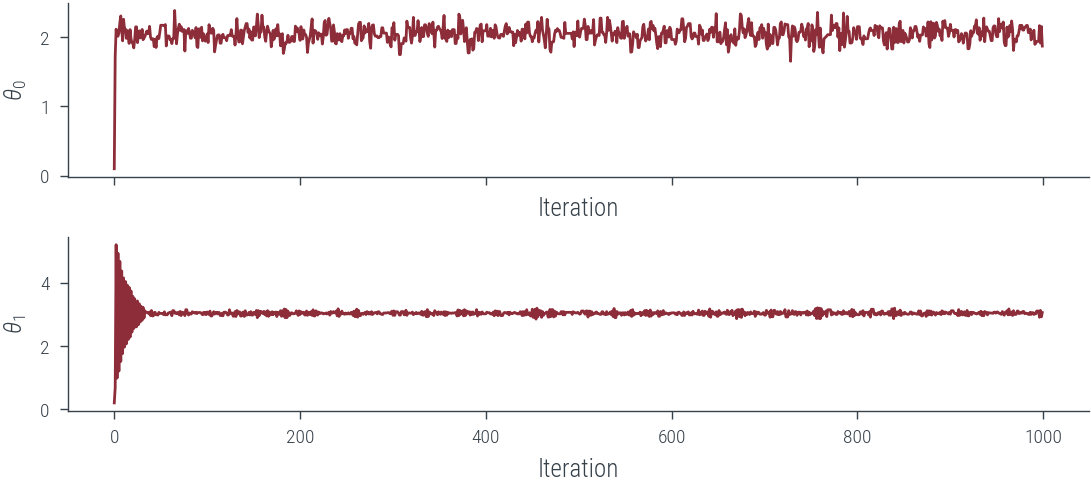

In [51]:
# Plot the traces corresponding to the two parameters
fig, axes = plt.subplots(2, 1, sharex=True)

for i, param_vals in enumerate(params_hmc.T):
    axes[i].plot(param_vals, label="Trace")
    axes[i].set_xlabel("Iteration")
    axes[i].set_ylabel(rf"$\theta_{i}$")

NameError: name 'sns' is not defined

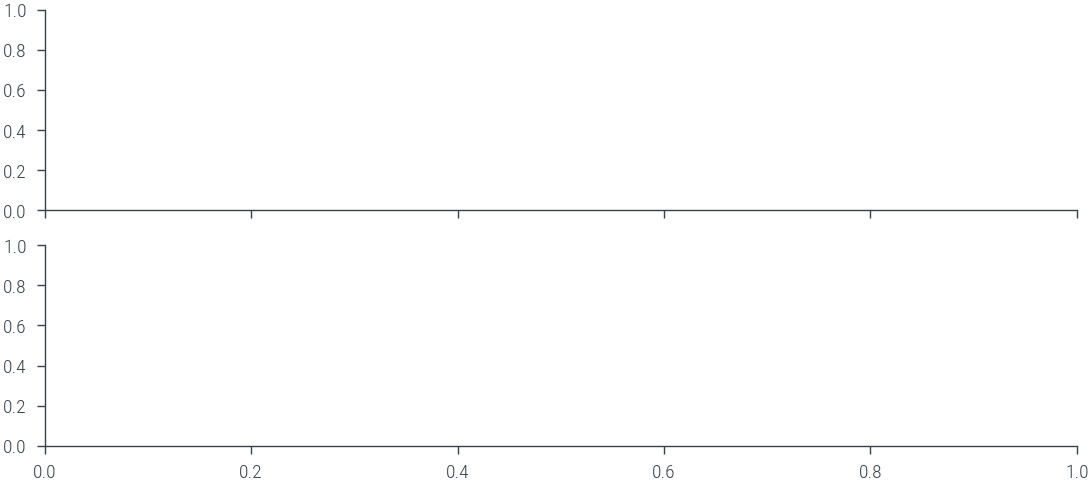

In [46]:
# Plot KDE of the samples for the two parameters
fig, axes = plt.subplots(2, 1, sharex=True)

for i, param_vals in enumerate(params_hmc.T):
    sns.kdeplot(
        param_vals.detach().numpy(), label="Samples", shade=True, color="C1", ax=axes[i]
    )
    axes[i].set_ylabel(rf"$\theta_{i}$")

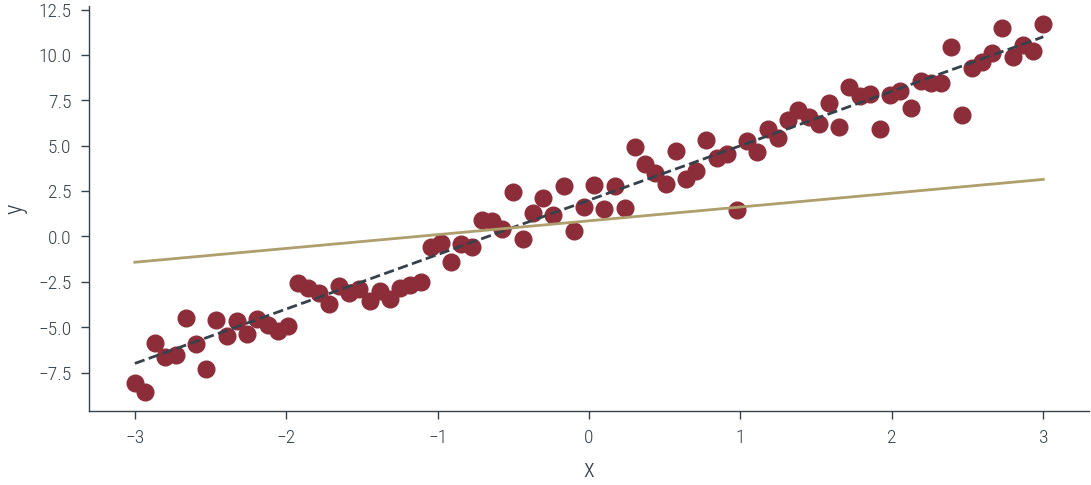

In [59]:
# Plot predictions
plt.figure()
plt.scatter(x_lin, y_lin, label="Data", color="C0")
plt.plot(x_lin, f(x_lin), label="Ground truth", color="C1", linestyle="--")
plt.xlabel("x")
plt.ylabel("y")

# Get posterior samples. Thin first 100 samples to remove burn-in
posterior_samples = params_hmc[100:].detach()
with torch.no_grad():
    y_hat = net(x_lin.unsqueeze(1))

# Plot mean and 95% confidence interval

plt.plot(x_lin, y_hat.ravel(), label="Mean", color="C2")

In [54]:
y_hat.ravel()

tensor([-1.4220, -1.3707, -1.3194, -1.2681, -1.2168, -1.1656, -1.1143, -1.0630,
        -1.0117, -0.9604, -0.9091, -0.8579, -0.8066, -0.7553, -0.7040, -0.6527,
        -0.6014, -0.5501, -0.4989, -0.4476, -0.3963, -0.3450, -0.2937, -0.2424,
        -0.1912, -0.1399, -0.0886, -0.0373,  0.0140,  0.0653,  0.1165,  0.1678,
         0.2191,  0.2704,  0.3217,  0.3730,  0.4242,  0.4755,  0.5268,  0.5781,
         0.6294,  0.6807,  0.7320,  0.7832,  0.8345,  0.8858,  0.9371,  0.9884,
         1.0397,  1.0909,  1.1422,  1.1935,  1.2448,  1.2961,  1.3474,  1.3986,
         1.4499,  1.5012,  1.5525,  1.6038,  1.6551,  1.7064,  1.7576,  1.8089,
         1.8602,  1.9115,  1.9628,  2.0141,  2.0653,  2.1166,  2.1679,  2.2192,
         2.2705,  2.3218,  2.3730,  2.4243,  2.4756,  2.5269,  2.5782,  2.6295,
         2.6808,  2.7320,  2.7833,  2.8346,  2.8859,  2.9372,  2.9885,  3.0397,
         3.0910,  3.1423])

In [ ]:
# Now, solve the above using Hamiltorch's MCMC sample_model function


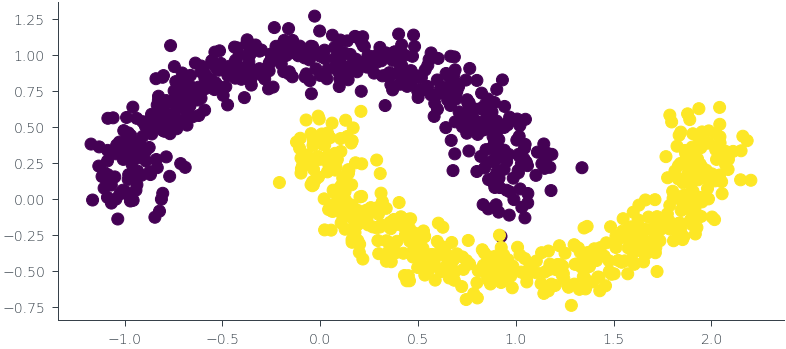

In [38]:
### Bayesian Logistic Regression

from sklearn.datasets import make_moons

# Generate data
x, y = make_moons(n_samples=1000, noise=0.1, random_state=0)

plt.scatter(x[:, 0], x[:, 1], c=y)

x = torch.tensor(x).float()
y = torch.tensor(y).float()
